In [1]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: GeForce GTX 1650


/home/brittany/py36_vir2/lib/python3.6/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU1 Quadro K2000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [2]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
files=[]
for dirname, _, filenames in os.walk('/home/brittany/uiuc_mcs/cs410/ClassificationCompetition/data/'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
print(files)

['/home/brittany/uiuc_mcs/cs410/ClassificationCompetition/data/test.jsonl', '/home/brittany/uiuc_mcs/cs410/ClassificationCompetition/data/train.jsonl']


In [4]:
pd_train=pd.read_json(files[1], lines=True) #, orient='split')
pd_train

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...
...,...,...,...
4995,NOT_SARCASM,@USER You don't . I have purchased a lot on Am...,[@USER Apologies for the inconvenience you fac...
4996,NOT_SARCASM,@USER #Emotions you say 🤔 never knew that I th...,"[@USER 🤔 idk tho , I think I ’ m #hungry . But..."
4997,NOT_SARCASM,"@USER @USER @USER You are so right ... "" Yes !...","[@USER @USER @USER Peace to you , and two coun..."
4998,NOT_SARCASM,@USER @USER @USER Another lazy delusional vote...,[Bernie Sanders told Elizabeth Warren in priva...


In [5]:
pd_test=pd.read_json(files[0], lines=True) #, orient='split')
pd_test

,id,response,context
0,twitter_1,"@USER @USER @USER My 3 year old , that just fi...","[Well now that ’ s problematic AF <URL>, @USER..."
1,twitter_2,@USER @USER How many verifiable lies has he to...,[Last week the Fake News said that a section o...
2,twitter_3,@USER @USER @USER Maybe Docs just a scrub of a...,[@USER Let ’ s Aplaud Brett When he deserves i...
3,twitter_4,@USER @USER is just a cover up for the real ha...,[Women generally hate this president . What's ...
4,twitter_5,@USER @USER @USER The irony being that he even...,"[Dear media Remoaners , you excitedly sharing ..."
...,...,...,...
1795,twitter_1796,@USER @USER @USER is definitely the best out t...,[I have been a business customer of MWeb @USER...
1796,twitter_1797,@USER @USER Ye let her out run wild and infect...,[A woman refuses to have her temperature taken...
1797,twitter_1798,"@USER @USER @USER Thanks for that , I would ha...",[The reason big government wants @USER out is ...
1798,twitter_1799,@USER @USER @USER Yes also #found this on #new...,[Happy #musicmonday and #thanks for #all your ...


## Using only response

In [6]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
  text = hashtags.sub(' hashtag', text)
  text = mentions.sub(' entity', text)
  return text.strip().lower()
  
def match_expr(pattern, string):
  return not pattern.search(string) == None

def get_data_wo_urls(dataset):
    link_with_urls = dataset.text.apply(lambda x: match_expr(urls, x))
    return dataset[[not e for e in link_with_urls]]

In [7]:
pd_train['response_processed']=pd_train.response.apply(process_text)
pd_train

,label,response,context,response_processed
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...,entity entity entity i don't get this .. obvio...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...,entity entity trying to protest about . talkin...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...,entity entity entity he makes an insane about ...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...,entity entity meanwhile trump won't even relea...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...,entity entity pretty sure the anti-lincoln cro...
...,...,...,...,...
4995,NOT_SARCASM,@USER You don't . I have purchased a lot on Am...,[@USER Apologies for the inconvenience you fac...,entity you don't . i have purchased a lot on a...
4996,NOT_SARCASM,@USER #Emotions you say 🤔 never knew that I th...,"[@USER 🤔 idk tho , I think I ’ m #hungry . But...",entity hashtag you say 🤔 never knew that i thi...
4997,NOT_SARCASM,"@USER @USER @USER You are so right ... "" Yes !...","[@USER @USER @USER Peace to you , and two coun...","entity entity entity you are so right ... "" ye..."
4998,NOT_SARCASM,@USER @USER @USER Another lazy delusional vote...,[Bernie Sanders told Elizabeth Warren in priva...,entity entity entity another lazy delusional v...


In [8]:
pd_test['response_processed']=pd_test.response.apply(process_text)
pd_test

,id,response,context,response_processed
0,twitter_1,"@USER @USER @USER My 3 year old , that just fi...","[Well now that ’ s problematic AF <URL>, @USER...","entity entity entity my 3 year old , that just..."
1,twitter_2,@USER @USER How many verifiable lies has he to...,[Last week the Fake News said that a section o...,entity entity how many verifiable lies has he ...
2,twitter_3,@USER @USER @USER Maybe Docs just a scrub of a...,[@USER Let ’ s Aplaud Brett When he deserves i...,entity entity entity maybe docs just a scrub o...
3,twitter_4,@USER @USER is just a cover up for the real ha...,[Women generally hate this president . What's ...,entity entity is just a cover up for the real ...
4,twitter_5,@USER @USER @USER The irony being that he even...,"[Dear media Remoaners , you excitedly sharing ...",entity entity entity the irony being that he e...
...,...,...,...,...
1795,twitter_1796,@USER @USER @USER is definitely the best out t...,[I have been a business customer of MWeb @USER...,entity entity entity is definitely the best ou...
1796,twitter_1797,@USER @USER Ye let her out run wild and infect...,[A woman refuses to have her temperature taken...,entity entity ye let her out run wild and infe...
1797,twitter_1798,"@USER @USER @USER Thanks for that , I would ha...",[The reason big government wants @USER out is ...,"entity entity entity thanks for that , i would..."
1798,twitter_1799,@USER @USER @USER Yes also #found this on #new...,[Happy #musicmonday and #thanks for #all your ...,entity entity entity yes also hashtag this on ...


<AxesSubplot:>

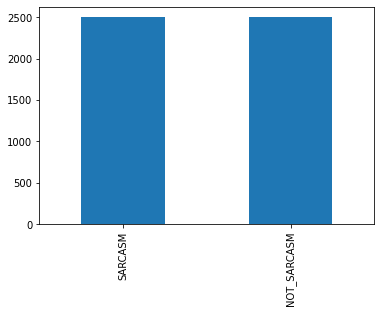

In [9]:
pd_train['label'].value_counts().plot(kind='bar')

In [10]:
pd_train_x1=pd_train[['response_processed', 'label']]
pd_train_x1.loc[:,'new_label'] = pd_train_x1.label.map({'NOT_SARCASM':0,'SARCASM':1})
pd_train_x1=pd_train_x1.drop(['label'],axis=1)
pd_train_x1.rename(columns={'response_processed': 'text', 'new_label': 'label'}, inplace=True)
#pd_train_x1=pd_train_x1[['label','text']]
pd_train_x1

/home/brittany/py36_vir2/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/brittany/py36_vir2/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,text,label
0,entity entity entity i don't get this .. obvio...,1
1,entity entity trying to protest about . talkin...,1
2,entity entity entity he makes an insane about ...,1
3,entity entity meanwhile trump won't even relea...,1
4,entity entity pretty sure the anti-lincoln cro...,1
...,...,...
4995,entity you don't . i have purchased a lot on a...,0
4996,entity hashtag you say 🤔 never knew that i thi...,0
4997,"entity entity entity you are so right ... "" ye...",0
4998,entity entity entity another lazy delusional v...,0


In [11]:
pd_test_x1=pd_test[['id', 'response_processed']]
pd_test_x1.rename(columns={'id': 'id', 'response_processed': 'text'}, inplace=True)
pd_test_x1

/home/brittany/py36_vir2/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,text
0,twitter_1,"entity entity entity my 3 year old , that just..."
1,twitter_2,entity entity how many verifiable lies has he ...
2,twitter_3,entity entity entity maybe docs just a scrub o...
3,twitter_4,entity entity is just a cover up for the real ...
4,twitter_5,entity entity entity the irony being that he e...
...,...,...
1795,twitter_1796,entity entity entity is definitely the best ou...
1796,twitter_1797,entity entity ye let her out run wild and infe...
1797,twitter_1798,"entity entity entity thanks for that , i would..."
1798,twitter_1799,entity entity entity yes also hashtag this on ...


In [12]:
from sklearn.model_selection import train_test_split
TRAIN_SIZE = 0.75
VAL_SIZE = 0.05
dataset_count = len(pd_train_x1)

df_train_val, df_test = train_test_split(pd_train_x1, test_size=1-TRAIN_SIZE-VAL_SIZE, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=VAL_SIZE / (VAL_SIZE + TRAIN_SIZE), random_state=42)

print("TRAIN size:", len(df_train))
print("VAL size:", len(df_val))
print("TEST size:", len(df_test))

TRAIN size: 3750
VAL size: 250
TEST size: 1000


In [13]:
df_train = get_data_wo_urls(df_train)
df_train.head()

,text,label
212,entity that sounded a bit creepy . now i'm pan...,1
3012,day thirteen of three hundred and sixty five ....,0
2823,entity entity hashtag for life due to high tox...,0
2993,entity entity you are a typical killary suppor...,0
128,entity entity entity i would like to give you ...,1


In [14]:
!mkdir dataset
df_train.sample(frac=1.0).reset_index(drop=True).to_csv('dataset/train.tsv', sep='\t', index=None, header=None)
df_val.to_csv('dataset/dev.tsv', sep='\t', index=None, header=None)
df_test.to_csv('dataset/test.tsv', sep='\t', index=None, header=None)
! cd dataset && ls

mkdir: cannot create directory ‘dataset’: File exists
dev.tsv  test.tsv  train.tsv


In [26]:
#!pip3 install tensorflow-gpu==11.1.105
!pip install tensorflow-gpu

In [29]:
!pip install BertLibrary
from transformers import pipeline
!pip install bert-tensorflow
from BertLibrary import BertFTModel
import numpy as np

AttributeError: module 'BertLibrary' has no attribute 'bert'

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()    

In [28]:
ft_model = BertFTModel( model_dir='uncased_L-12_H-768_A-12',
                         ckpt_name="bert_model.ckpt",
                         labels=['0','1'],
                         lr=1e-05,
                         num_train_steps=30000,
                         num_warmup_steps=1000,
                         ckpt_output_dir='output',
                         save_check_steps=1000,
                         do_lower_case=False,
                         max_seq_len=50,
                         batch_size=32,
                         )


ft_trainer =  ft_model.get_trainer()
ft_evaluator = ft_model.get_evaluator()

NameError: name 'BertFTModel' is not defined

In [30]:
ft_trainer.train_from_file('dataset', 35000)

NameError: name 'ft_trainer' is not defined

In [31]:
ft_evaluator.evaluate_from_file('dataset', checkpoint="output/model.ckpt-35000") 

NameError: name 'ft_evaluator' is not defined